In [1]:
from src.acoustic_analyser import frame
import numpy as np

test_frame = frame.from_file(
    member_file="test_member.json", constraint_file="test_constraint.csv", debug=False
)

free_end = test_frame.fixed_end(member_id=0)
free_end = test_frame.free_end(member_id=1)

matrix = test_frame.get_equation_matrix(w=10)
print(abs(np.linalg.det(matrix)))

0.22435014400184508


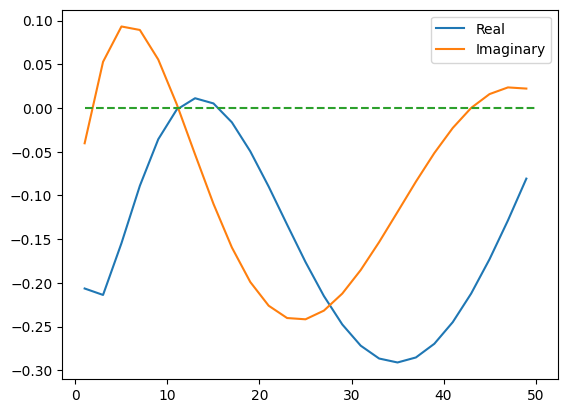

In [2]:
_ = test_frame.get_frequency_graph(lower_limit=1, upper_limit=50, step_size=2)

In [3]:
test_frame.get_natural_frequency(lower_limit=10, upper_limit=12)

11.166015625